# Recommendation Engine

We have to build a recommendation system to recommend products for customers based on the popularity and their previous ratings for other products.

The recommendation system is designed in 2 parts based on the business context:

Part I: Popularity Based Recommendation Engine targeted for new customers.

Part II: Model - Based Collaborative Filtering System based on customer's purchase history and ratings provided by other. users who bought similar items

When a new customer without any previous purchase history visits the site for the first time, he/she is recommended the most popular products sold on the company's website. Once, he/she makes a purchase, the recommendation system updates and recommends other products based on the purchase history and ratings provided by other users on the website. The latter part is done using collaborative filtering techniques.

- Importing Required Libraries :

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split

- Loading Dataset : 

In [2]:
# Giving Column names :
df = pd.read_csv('ratings_Beauty.csv')
df.head(5)

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023070 entries, 0 to 2023069
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   UserId     object 
 1   ProductId  object 
 2   Rating     float64
 3   Timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 61.7+ MB


In [4]:
df.shape

(2023070, 4)

In [5]:
df.describe()

,Rating,Timestamp
count,2.023070e+06,2.023070e+06
mean,4.149036e+00,1.360389e+09
std,1.311505e+00,4.611860e+07
min,1.000000e+00,9.087552e+08
25%,4.000000e+00,1.350259e+09
50%,5.000000e+00,1.372810e+09
75%,5.000000e+00,1.391472e+09
max,5.000000e+00,1.406074e+09


- Check Missing Values :

In [6]:
df.isnull().sum()
# OR : 
# df.isna().sum()

UserId       0
ProductId    0
Rating       0
Timestamp    0
dtype: int64

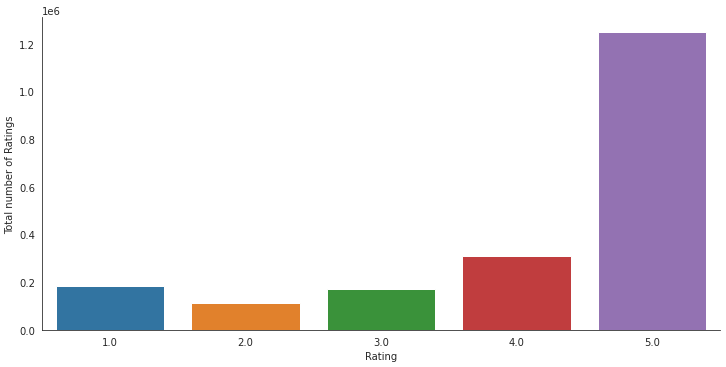

In [7]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data = df, aspect = 2.0,kind = 'count')
    g.set_ylabels("Total number of Ratings") 

In [8]:
# Number of unique User_Id in the data :

print('Number of unique users in Raw data = ', df['UserId'].nunique())

# Number of unique Product_Id in the data :

print('Number of unique product in Raw data = ', df['ProductId'].nunique())

Number of unique users in Raw data =  1210271
Number of unique product in Raw data =  249274


In [9]:
df.dropna()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200
...,...,...,...,...
2023065,A3DEHKPFANB8VA,B00LORWRJA,5.0,1405296000
2023066,A3DEHKPFANB8VA,B00LOS7MEE,5.0,1405296000
2023067,AG9TJLJUN5OM3,B00LP2YB8E,5.0,1405382400
2023068,AYBIB14QOI9PC,B00LPVG6V0,5.0,1405555200


# Popularity Based Recommendation Engine :

In [10]:
popular_products = pd.DataFrame(df.groupby('ProductId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(10)

,Rating
ProductId,
B001MA0QY2,7533
B0009V1YR8,2869
B0043OYFKU,2477
B0000YUXI0,2143
B003V265QW,2088
B000ZMBSPE,2041
B003BQ6QXK,1918
B004OHQR1Q,1885
B00121UVU0,1838


<AxesSubplot:xlabel='ProductId'>

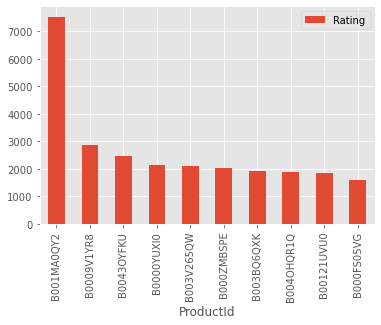

In [11]:
plt.style.use("ggplot")
# ggplot is used to create publication qulaity plots. It's part of plotnine implementation of Python,
# inspored by ggplot2 package from R.plotnine
most_popular.head(10).plot(kind = "bar")

 Using a Utility Matrix:

An utlity matrix consists of all possible user-item preferences (i.e. ratings) details represented as a matrix. The utility matrix is sparce as none of the users would buy all the items in the list, hence, most of the values are unknown.

In [12]:
# Creating a Subset to make it less sparse / denser :

df1 = df.head(10000)

Pivot Table - A Pivot Table is used to summarise, sort, reorganise, group, count, total or average data stored in a table. It allows us to transform columns into rows and rows into columns. It allows grouping by any field (column), and using advanced calculations on them.

In [13]:
ratings_utility_matrix = df1.pivot_table(values='Rating', index='UserId', columns='ProductId', fill_value=0)
ratings_utility_matrix.head()

ProductId,0205616461,0558925278,0733001998,0737104473,0762451459,1304139212,1304139220,130414089X,130414643X,1304146537,...,B000052YPE,B000052YPF,B000052YPG,B000052YPH,B000052YPM,B000052YPU,B000052YPV,B000052YPY,B000052YQ0,B000052YQ2
UserId,,,,,,,,,,,,,,,,,,,,,
A00205921JHJK5X9LNP42,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A024581134CV80ZBLIZTZ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A03056581JJIOL5FSKJY7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A03099101ZRK4K607JVHH,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0505229A7NSH3FRXRR4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
ratings_utility_matrix.shape

(9697, 886)

In [15]:
# Calucating the density of the Utility Matrix :

given_num_of_ratings = np.count_nonzero(ratings_utility_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = ratings_utility_matrix.shape[0] * ratings_utility_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

given_num_of_ratings =  10000
possible_num_of_ratings =  8591542
density: 0.12%


The density value of the matrix shows that it is a sparse matrix.

In [16]:
# Split the data randomly into train and test datasets into 70:30 ratio :

train_data, test_data = train_test_split(df1, test_size = 0.3, random_state=0)
train_data.head()

,UserId,ProductId,Rating,Timestamp
7681,A3PTZFRD34YJ2P,B000052YM8,5.0,1306454400
9031,A39X2H1HNGDI70,B000052YOR,5.0,1389744000
3691,AVO9DK715GQB3,B000050B6U,5.0,1346544000
202,A29AQSCFQ1OZ9R,535795545X,5.0,1360022400
5625,AAZQ1XIH59FPF,B000052Y5F,5.0,1300579200


In [17]:
print('Shape of training data: ',train_data.shape)
print('Shape of testing data: ',test_data.shape)

Shape of training data:  (7000, 4)
Shape of testing data:  (3000, 4)


In [18]:
# Count of User_Id for each unique product as recommendation score :

train_data_grouped = train_data.groupby('ProductId').agg({'UserId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'UserId': 'Score'},inplace=True)
train_data_grouped.head()

,ProductId,Score
0,0205616461,1
1,0558925278,2
2,0733001998,1
3,0737104473,1
4,0762451459,1


In [19]:
# Sort the products on recommendation score :

train_data_sort = train_data_grouped.sort_values(['Score', 'ProductId'], ascending = [0,1]) 
      
# Generate a recommendation rank based upon score :

train_data_sort['Rank'] = train_data_sort['Score'].rank(ascending=0, method='first') 
          
# Get the top 5 recommendations :

popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations 

,ProductId,Score,Rank
589,B00004TUBL,396,1.0
709,B000052YM7,300,2.0
603,B000050B6U,262,3.0
747,B000052YP6,245,4.0
635,B000052XZP,218,5.0


In [20]:
# Use popularity based recommender model to make predictions :

def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    # Add user_id column for which the recommendations are being generated :
    
    user_recommendations['UserId'] = user_id 
      
    # Bring user_id column to the front :
    
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [21]:
n = input("Enter UserId : ")
find_recom =  list(map(int,n.split()))  
for i in find_recom:
    print(str("The list of recommendations for the UserId : %d\n" %(i)))
    print(recommend(i))    
    print("\n") 

Enter UserId : 25
The list of recommendations for the UserId : 25

     UserId   ProductId  Score  Rank
589      25  B00004TUBL    396   1.0
709      25  B000052YM7    300   2.0
603      25  B000050B6U    262   3.0
747      25  B000052YP6    245   4.0
635      25  B000052XZP    218   5.0




Since, it is a Popularity recommender model, so, all the three users are given the same recommendations. Here, we predict the products based on the popularity. It is not personalized to particular user. It is a non-personalized recommender system.

# Model - Based Collaborative Filtering System:

It recommends items to the users based on purchase history and similarity of ratings provided by other users who bought items to that of a particular customer.

In [22]:
df1 = df.head(10000)

Pivot Table - A Pivot Table is used to summarise, sort, reorganise, group, count, total or average data stored in a table. It allows us to transform columns into rows and rows into columns. It allows grouping by any field (column), and using advanced calculations on them.

In [23]:
ratings_utility_matrix = df1.pivot_table(values='Rating', index='UserId', columns='ProductId', fill_value=0)
ratings_utility_matrix.head()

ProductId,0205616461,0558925278,0733001998,0737104473,0762451459,1304139212,1304139220,130414089X,130414643X,1304146537,...,B000052YPE,B000052YPF,B000052YPG,B000052YPH,B000052YPM,B000052YPU,B000052YPV,B000052YPY,B000052YQ0,B000052YQ2
UserId,,,,,,,,,,,,,,,,,,,,,
A00205921JHJK5X9LNP42,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A024581134CV80ZBLIZTZ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A03056581JJIOL5FSKJY7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A03099101ZRK4K607JVHH,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0505229A7NSH3FRXRR4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
ratings_utility_matrix.shape

(9697, 886)

In [25]:
# Transposing the Matrix : 

X = ratings_utility_matrix.T
X.head()

UserId,A00205921JHJK5X9LNP42,A024581134CV80ZBLIZTZ,A03056581JJIOL5FSKJY7,A03099101ZRK4K607JVHH,A0505229A7NSH3FRXRR4,A05492663T95KW63BR75K,A059547920Q3LZVFHLPI3,A07410232KYRFR25CIUGJ,A082796624UNM47DSAI6K,A0864963DOAY7LXGS5I6,...,AZW1HXXYAC15B,AZWRTJPN7NXT,AZWTXHXZXFAYP,AZYQEFB9Y5N22,AZZHB6U54UDYW,AZZHJZP4GQPPZ,AZZNK89PXD006,AZZOFVMQC0BJG,AZZQXL8VDCFTV,AZZTJQ7CQZUD8
ProductId,,,,,,,,,,,,,,,,,,,,,
0205616461,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0558925278,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0733001998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0737104473,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0762451459,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
X.shape

(886, 9697)

In [27]:
# Unique Products in subset of data :

X1 = X

SVD - The singular value decomposition (SVD) provides another way to factorize a matrix,
    into singular vectors and singular values.

Matrix Decomposition - Matrix decomposition is matrix factorization which separates a matrix into two other matrices that are typically much easier to solve than the original matrix.
    Not only does this make the problem easy to solve,
    but it reduces the amount of time required by a computer to calculate the answer.

    

In [28]:
# Decomposing the Matrix :

SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(886, 10)

In [29]:
# Correlation Matrix :
# A correlation matrix shows the interdependence of variable quantities.

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(886, 886)

In [30]:
# Isolating a random Product from the Correlation Matrix :

n = int(input("Enter value of index between 1 to 886 : "))
X.index[n]

Enter value of index between 1 to 886 : 56


'1906987238'

In [31]:
# Index of product ID purchased by customer : 

m = X.index[n]
product_names = list(X.index)
product_ID = product_names.index(m)
product_ID

56

In [32]:
# Correlation for all items with the item purchased by this customer based on items
# rated by other customers people who bought the same product :

correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(886,)

Recommending Top 10 highly co-related products in sequence :

In [33]:
Recommend = list(X.index[correlation_product_ID > 0.70])

# Removes the item(s) already bought by the customer :

Recommend.remove(m) 

Recommend[0:10]

['0558925278',
 '130414089X',
 '1304146537',
 '1304168522',
 '1304351475',
 '1304482596',
 '1304482634',
 '1304488608',
 '1304495396',
 '130451112X']

Here are the top 10 products to be displayed by the recommendation system to the above customer based on the purchase history of other customers in the website.